# Check dataflow

- Example codes to visually check:
    - data augmentations
    - data batching

- Performance benchmarks

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import torch
import torchvision

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

os.environ['CIFAR10_ROOT'] = '/media/user/fast_storage/tensorpack_data/cifar10_data/'
sys.path.append("..")

CIFAR10_ROOT = os.environ['CIFAR10_ROOT']

In [3]:
train_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=True, download=False)

## Simple data visualization

In [4]:
from common_utils.dataflow_visu_utils import display_basic_dataset

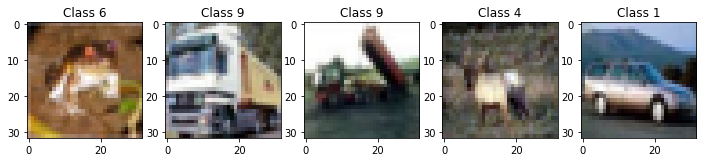

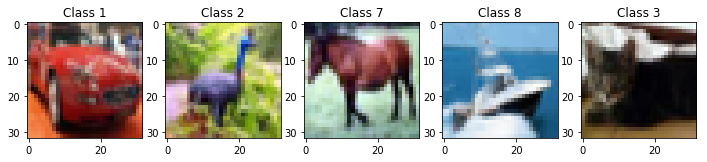

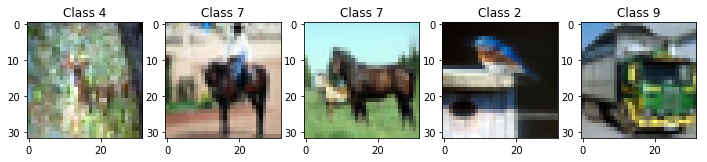

In [5]:
display_basic_dataset(train_ds, max_datapoints=15)

## Setup and check data augmentations

In [5]:
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from common_utils.dataflow import TransformedDataset
from common_utils.imgaug import ToNumpy, RandomOrder, RandomChoice, RandomFlip
from common_utils.imgaug import RandomAffine, RandomAdd, RandomCrop, ColorJitter, CenterCrop
from common_utils.imgaug import Brightness, Contrast, Saturation
from common_utils.imgaug import restore_transform

Restore a transform from json string

In [6]:
transforms_json_str = '''{"Compose":
                            {"transforms": [{"ToNumpy": {}},
                                            {"RandomChoice": {"transforms": [
                                                {"RandomAffine": {"translate": [0.05, 0.05],
                                                                    "rotation": [-60, 60],
                                                                    "scale": [0.95, 1.05]}},
                                                {"RandomFlip": {"mode": "h", "proba": 0.5}},
                                                {"RandomFlip": {"mode": "v", "proba": 0.5}}]}},
                                            {"ToTensor": {}},
                                            {"ColorJitter": {"brightness": 0.4, 
                                                             "contrast": 0.4, 
                                                             "saturation": 0.4}},
                                            {"Normalize": {"std": [0.229, 0.224, 0.225],
                                                           "mean": [0.485, 0.456, 0.406]}}
                                            ]
                            }
                        }'''


custom_transforms = {
    "ToNumpy": ToNumpy,    
    "RandomCrop": RandomCrop,
    "CenterCrop": CenterCrop,
    "RandomChoice": RandomChoice,
    "RandomAffine": RandomAffine,
    "RandomFlip": RandomFlip,
    "ColorJitter": ColorJitter,
    "Brightness": Brightness,
    "Contrast": Contrast,    
}

In [7]:
train_transforms = restore_transform(transforms_json_str, custom_transforms)

In [8]:
train_transforms.transforms

In [9]:
aug_train_ds = TransformedDataset(train_ds, x_transforms=train_transforms)

In [10]:
from common_utils.dataflow_visu_utils import display_data_augmentations

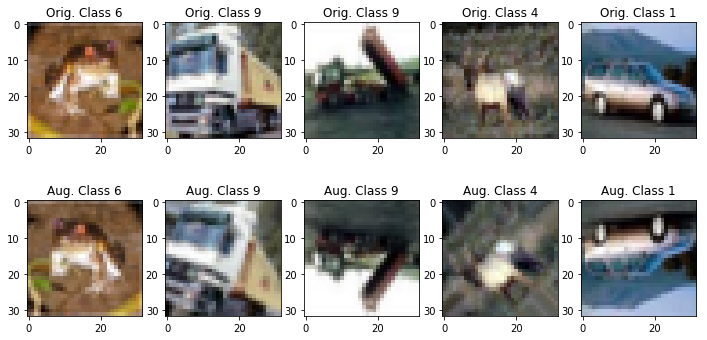

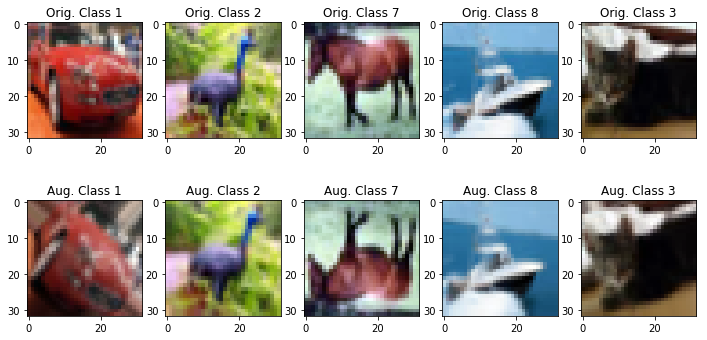

In [13]:
display_data_augmentations(train_ds, aug_train_ds, max_datapoints=10)

## Setup and check complete dataflow : augmentations and batching

In [11]:
from common_utils.dataflow_visu_utils import display_batches
from torch.utils.data import DataLoader

In [12]:
train_batches = DataLoader(aug_train_ds, batch_size=5, drop_last=True, num_workers=2)

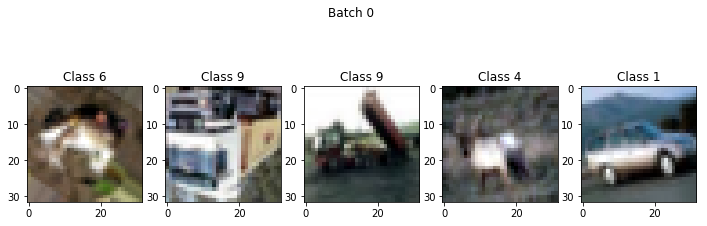

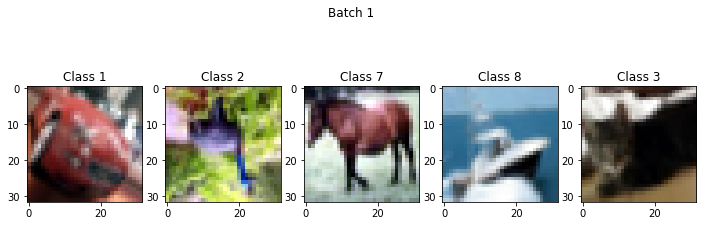

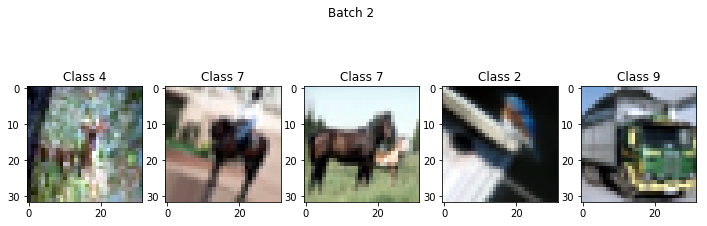

In [17]:
display_batches(train_batches, max_batches=3)

## Performance benchmarks

In [49]:
train_batches = DataLoader(aug_train_ds, batch_size=64, drop_last=True, num_workers=12, pin_memory=True)

In [50]:
for batch_x, batch_y in train_batches:
    print(batch_x.type(), batch_x.size())
    break

torch.FloatTensor torch.Size([64, 3, 32, 32])


Most common method

In [51]:
!nvidia-smi

Fri Nov 24 22:22:12 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0     Off |                  N/A |
| 29%   45C    P8    29W / 250W |    329MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [52]:
%%timeit -r3 -n5
for batch_x, batch_y in train_batches:
    batch_x = batch_x.cuda()
    batch_x.sum(dim=0)
    pass

2.16 s ± 9.37 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


Use special collate function => 
```
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
```

Derived class of DataLoader

In [53]:
import collections
from torch.utils.data.dataloader import DataLoaderIter, DataLoader

def to_cuda(batch):
    if torch.is_tensor(batch):
        return batch.cuda(async=True)
    elif isinstance(batch, string_classes):
        return batch
    elif isinstance(batch, collections.Mapping):
        return {k: to_cuda(sample) for k, sample in batch.items()}
    elif isinstance(batch, collections.Sequence):
        return [to_cuda(sample) for sample in batch]
    else:
        raise TypeError(("batch must contain tensors, numbers, dicts or lists; found {}"
                     .format(type(batch[0]))))
    
class OnGPUDataLoaderIter(DataLoaderIter):

    def __next__(self):
        batch = super(OnGPUDataLoaderIter, self).__next__()
        return to_cuda(batch)

    next = __next__  # Python 2 compatibility


class OnGPUDataLoader(DataLoader):

    def __iter__(self):
        return OnGPUDataLoaderIter(self)

In [54]:
!nvidia-smi

Fri Nov 24 22:22:51 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0     Off |                  N/A |
| 29%   50C    P2    76W / 250W |    329MiB / 11170MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [55]:
train_batches = OnGPUDataLoader(aug_train_ds, batch_size=64, drop_last=True, 
                                num_workers=12, pin_memory=True)

In [56]:
%%timeit -r3 -n5
for batch_x, batch_y in train_batches:
    batch_x.sum(dim=0)
    pass

2.14 s ± 4.98 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
